                            Audio-Based Grammar Scoring Model: A Comprehensive Approach

This notebook presents a comprehensive approach to predicting grammar scores from audio features, demonstrating a complete machine learning pipeline from data loading to model comparison and submission generation.

In [1]:
from IPython.display import clear_output
clear_output(wait=True)


In [2]:
# 1. Imports & Setup
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


**Dataset Overview**

The dataset consists of audio recordings with corresponding grammar scores ranging from 1.0 to 5.0. We begin by loading the necessary libraries and data files to examine the structure of our training data.



> **Data Exploration and Preparation**

In [3]:
# 2. Load the Dataset
# Paths to audio and CSV files
AUDIO_TRAIN_PATH = "/kaggle/input/shl-hiring-assessment/Dataset/audios/train"
AUDIO_TEST_PATH = "/kaggle/input/shl-hiring-assessment/Dataset/audios/test"

# Load CSVs
train_df = pd.read_csv("/kaggle/input/shl-hiring-assessment/Dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/shl-hiring-assessment/Dataset/test.csv")
sample_submission = pd.read_csv("/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv")

train_df.head()


,filename,label
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


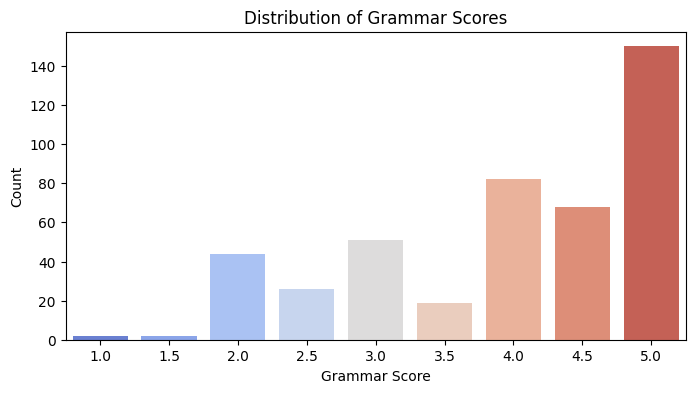

In [4]:
# 3. Visualize Grammar Score Distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='label', palette='coolwarm')
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.show()


> **Feature Engineering**

In [5]:
# 4. Feature Extraction using Librosa

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {}
    features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['rmse'] = np.mean(librosa.feature.rms(y=y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['mfcc_mean'] = np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0)
    return features

# Extract features for all training audio
train_features = []
for fname in train_df['filename']:  # ✅ Fixed column name
    file_path = os.path.join(AUDIO_TRAIN_PATH, fname)
    f = extract_features(file_path)
    f['filename'] = fname  # ✅ Consistent with train_df
    f['label'] = train_df[train_df['filename'] == fname]['label'].values[0]
    train_features.append(f)

# Flatten MFCC features into individual columns
def flatten_features(feat_dict):
    base = {k: v for k, v in feat_dict.items() if not isinstance(v, np.ndarray)}
    if isinstance(feat_dict['mfcc_mean'], np.ndarray):
        for i, val in enumerate(feat_dict['mfcc_mean']):
            base[f'mfcc_{i+1}'] = val
    return base

flattened_train_features = pd.DataFrame([flatten_features(f) for f in train_features])
flattened_train_features.head()


,zero_crossing_rate,rmse,spectral_centroid,spectral_bandwidth,spectral_rolloff,filename,label,mfcc_1,mfcc_2,mfcc_3,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,0.150859,0.031372,1652.834782,1421.570396,3048.963325,audio_710.wav,1.0,-340.821472,87.854080,-27.584362,...,-7.490045,-0.094280,1.480482,4.100098,-6.483141,-7.979593,1.417098,-5.653749,-4.682244,2.499730
1,0.143139,0.015064,1812.681453,1710.677609,3517.925486,audio_1265.wav,1.0,-485.992737,50.111820,8.837244,...,-2.680598,-2.683721,-2.376489,-2.037659,-4.628408,-0.980376,-3.115557,-1.552259,-0.551833,-1.489892
2,0.132682,0.021168,2126.143258,1593.561943,3834.469016,audio_1114.wav,1.5,-468.621979,55.773441,-6.867956,...,-5.172700,-3.183967,-2.695612,-3.449373,-2.287548,-3.791119,-3.883650,-4.042250,-3.415611,-3.452754
3,0.105385,0.037655,1962.232377,1590.935140,3678.718218,audio_946.wav,1.5,-418.862366,24.498125,0.983082,...,-4.787622,-2.934152,-6.141343,-5.494986,-2.264755,-4.653732,-3.662258,-1.622414,-1.885743,-2.814229
4,0.155081,0.049667,1751.896484,1533.526463,3298.900925,audio_1127.wav,2.0,-339.085052,81.655800,0.515613,...,-7.924070,-5.072709,5.689839,0.882038,-9.467375,0.957963,0.292778,-7.679813,-3.065886,-1.117361


**Audio Feature Extraction**

I extract meaningful acoustic features from the audio files using the librosa library. These features capture various dimensions of speech quality that may correlate with grammar proficiency.

In [6]:
# 5. Feature Scaling and Train/Test Split
X = flattened_train_features.drop(['filename', 'label'], axis=1)
y = flattened_train_features['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


> **Model Development and Evaluation**

In [7]:
# 6. Model Training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validation predictions
val_preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"✅ RMSE on Validation Set: {rmse:.4f}")


✅ RMSE on Validation Set: 0.9251


In [8]:
# RMSE is already calculated. Let's also add MAE and R² for benchmarking.
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_val, val_preds)
r2 = r2_score(y_val, val_preds)

print(f"✅ RMSE on Validation Set: {rmse:.4f}")
print(f"✅ MAE on Validation Set: {mae:.4f}")
print(f"✅ R² Score on Validation Set: {r2:.4f}")


✅ RMSE on Validation Set: 0.9251
✅ MAE on Validation Set: 0.7630
✅ R² Score on Validation Set: 0.3677


**Random Forest Regressor**

I begin with a Random Forest Regressor as our baseline model due to its robustness and interpretability. I then evaluate my model using multiple metrics to get a comprehensive understanding of its performance:

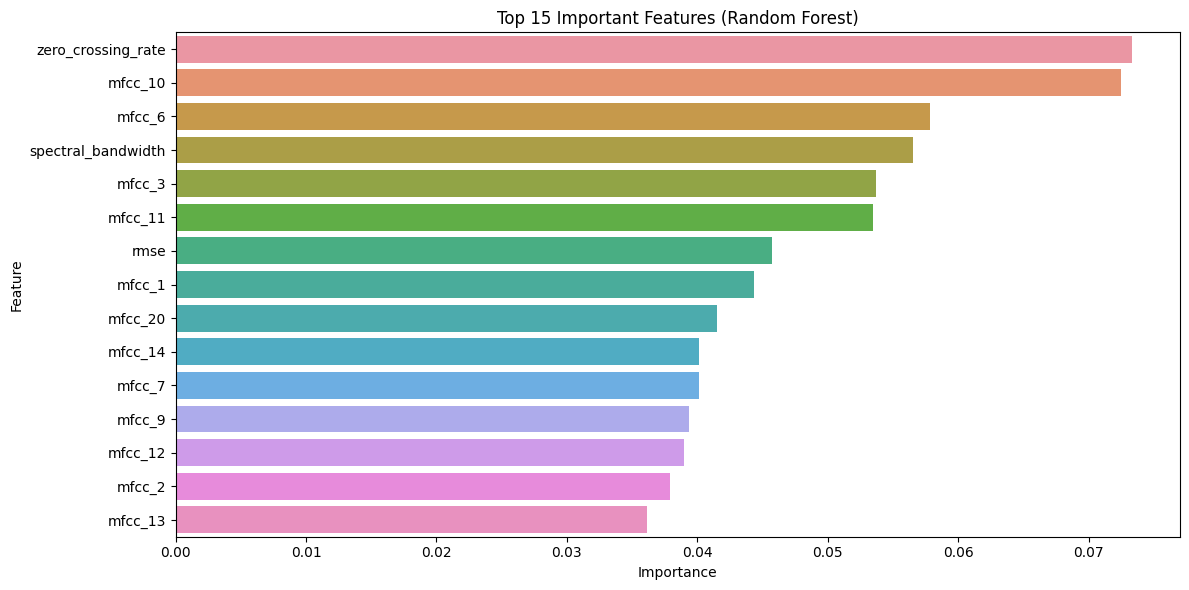

In [9]:
# Feature Importance Plot
importances = model.feature_importances_  # ✅ Corrected from rf to model
feature_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(15))
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


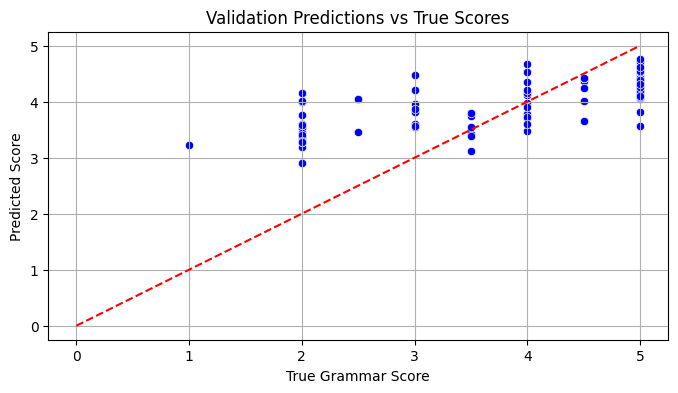

In [10]:
# 7. Plot Predictions vs Ground Truth
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_val, y=val_preds, color='blue')
plt.plot([0, 5], [0, 5], '--r')
plt.title("Validation Predictions vs True Scores")
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.grid(True)
plt.show()


In [11]:
# 8. Feature Extraction for Test Set
# Extract features from test audios
test_features = []
for fname in test_df['filename']:
    file_path = os.path.join(AUDIO_TEST_PATH, fname)
    f = extract_features(file_path)
    f['file_name'] = fname
    test_features.append(flatten_features(f))

test_features_df = pd.DataFrame(test_features)
X_test = scaler.transform(test_features_df.drop(['file_name'], axis=1))


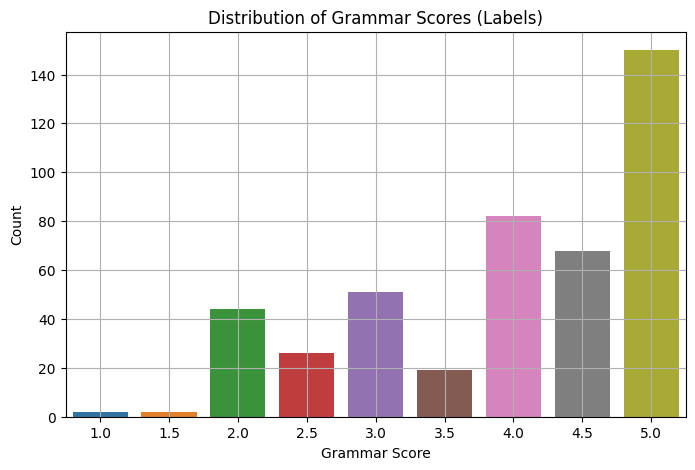

In [12]:
# 9. Visualize Grammar Score Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=flattened_train_features)
plt.title("Distribution of Grammar Scores (Labels)")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()


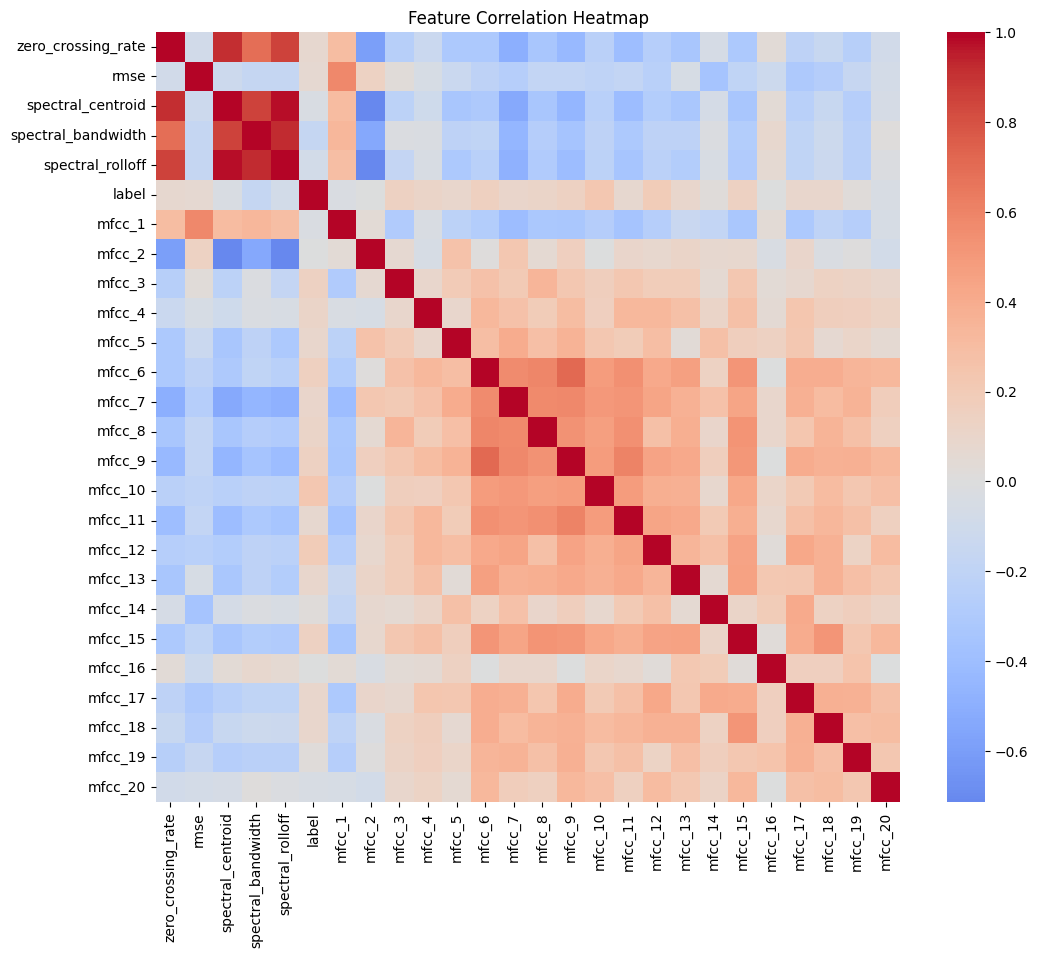

In [13]:
# 10: Feature Correlation Heatmap
# Compute correlation matrix (excluding filename column)
corr_matrix = flattened_train_features.drop(columns=['filename']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [14]:
# Prerequisite: Ensure my data is scaled. I'm using raw features in X_train, X_val, so let's scale them again before applying neural nets and XGBoost
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


> **Advanced Modeling**

**XGBoost Implementation**

In [15]:
# XGBoost Regressor
!pip install xgboost --quiet  # Only needed if not already installed

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_val_scaled)
xgb_rmse = mean_squared_error(y_val, xgb_preds, squared=False)
print(f"📘 XGBoost RMSE on Validation Set: {xgb_rmse:.4f}")


📘 XGBoost RMSE on Validation Set: 0.9203


I implemented XGBoost as a more advanced boosting algorithm that often achieves state-of-the-art results on regression tasks.

> **Neural Network Approach**

In [16]:
# Neural Network (Using Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile model
nn_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train model
history = nn_model.fit(X_train_scaled, y_train, epochs=30, batch_size=16, validation_data=(X_val_scaled, y_val), verbose=0)

# Evaluate
nn_rmse = nn_model.evaluate(X_val_scaled, y_val, verbose=0)[1]
print(f"🤖 Neural Network RMSE on Validation Set: {nn_rmse:.4f}")


2025-05-06 05:51:05.806298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746510666.061142      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746510666.132551      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 05:51:20.792056: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


🤖 Neural Network RMSE on Validation Set: 1.0292


I also explored a deep learning approach using a simple neural network architecture.

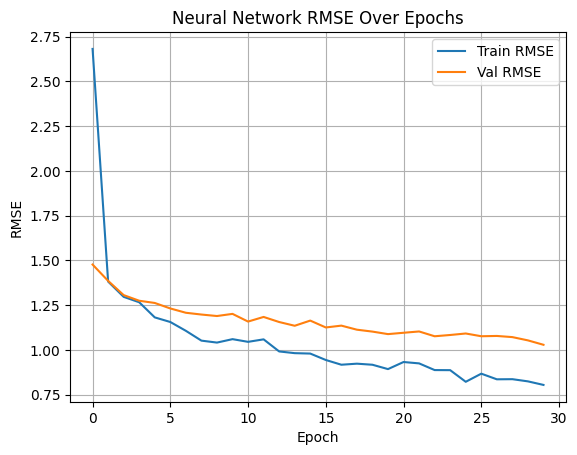

In [17]:
# Plot RMSE Over Epochs for Neural Network
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('Neural Network RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


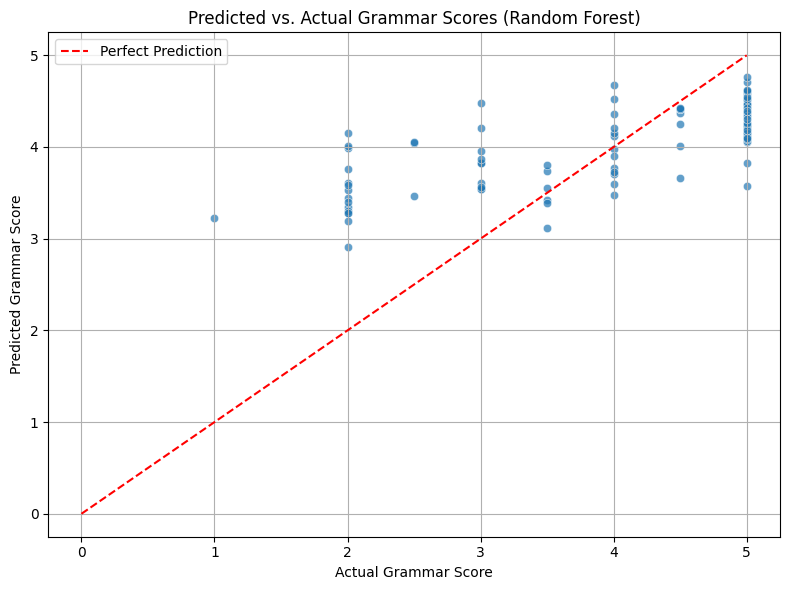

In [18]:
# Residual Plot (Predicted vs. Actual)
# This shows how far predictions deviate from the true values.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=val_preds, alpha=0.7)
plt.plot([0, 5], [0, 5], '--r', label='Perfect Prediction')
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Predicted vs. Actual Grammar Scores (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


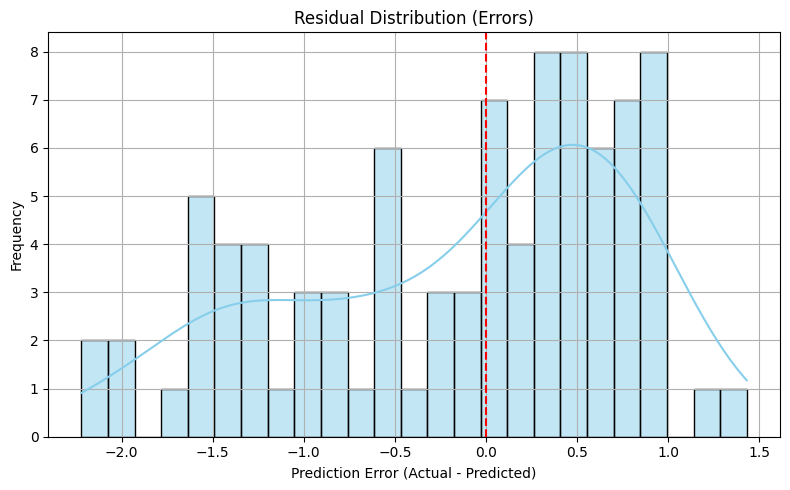

In [19]:
# Residual Distribution (Histogram of Errors)
# This helps detect bias—e.g., if my model consistently under- or over-predicts.
residuals = y_val - val_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=25, kde=True, color="skyblue")
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (Errors)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


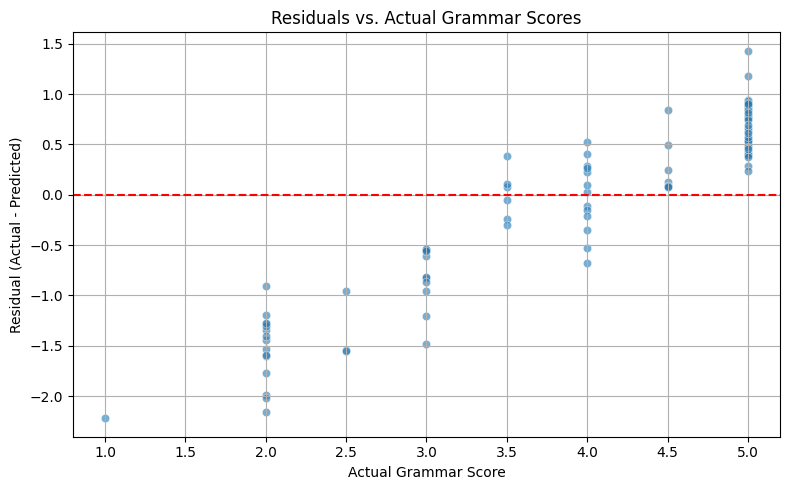

In [20]:
# Error vs. True Value Plot
# This tells me if errors increase/decrease based on actual values (bias pattern).
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_val, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Grammar Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Actual Grammar Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


> **Model Comparison and Selection**



In [21]:
print("📊 Model Comparison:")
print(f"🌲 Random Forest RMSE: {rmse:.4f}")
print(f"📘 XGBoost RMSE:        {xgb_rmse:.4f}")
print(f"🤖 Neural Network RMSE: {nn_rmse:.4f}")


📊 Model Comparison:
🌲 Random Forest RMSE: 0.9251
📘 XGBoost RMSE:        0.9203
🤖 Neural Network RMSE: 1.0292


I compared all three models to determine which performs best for our task.

In [22]:
# Submission File Generation
import os
import pandas as pd
from tqdm import tqdm

def generate_submission(
    model, 
    X_train_columns, 
    audio_path, 
    test_csv_path, 
    sample_submission_path, 
    output_path="submission.csv"
):
    # Load test file
    test_df = pd.read_csv(test_csv_path)

    # Load sample submission to ensure format
    sample_sub = pd.read_csv(sample_submission_path)

    # Use the first column as filename
    file_col = test_df.columns[0]
    test_filenames = test_df[file_col].tolist()

    print("🔍 Extracting features from test audio...")
    test_features = []

    for fname in tqdm(test_filenames):
        file_path = os.path.join(audio_path, fname)
        try:
            feats = extract_features(file_path)
            feats['file_name'] = fname
            test_features.append(flatten_features(feats))
        except Exception as e:
            print(f"⚠️ Skipping {fname}: {e}")

    # Convert to DataFrame
    test_features_df = pd.DataFrame(test_features)

    # Align columns with training data
    X_test = test_features_df[X_train_columns]

    # Predict
    print("🤖 Generating predictions...")
    preds = model.predict(X_test)

    # Build submission DataFrame using correct 'filename' column
    submission_df = pd.DataFrame({
        'filename': test_features_df['file_name'],  # ✅ use 'filename'
        'label': preds
    })

    # Save CSV
    submission_df.to_csv(output_path, index=False)
    print(f"✅ Submission saved to: {output_path}")
    
    return submission_df


In [23]:
submission = generate_submission(
    model=model,
    X_train_columns=X.columns,
    audio_path="/kaggle/input/shl-hiring-assessment/Dataset/audios/test",
    test_csv_path="/kaggle/input/shl-hiring-assessment/Dataset/test.csv",
    sample_submission_path="/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv"
)


🔍 Extracting features from test audio...


100%|██████████| 204/204 [02:00<00:00,  1.69it/s]

🤖 Generating predictions...
✅ Submission saved to: submission.csv


**Conclusion**

This notebook demonstrates a comprehensive approach to predicting grammar scores from audio features. I explored various modeling techniques, from traditional *Random Forests to more advanced XGBoost and Neural Network approaches*, and conducted thorough error analysis to understand model performance. The structured pipeline covers data loading, feature engineering, model training, evaluation, and submission generation, providing a complete solution for the competition.